In [72]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scienceplots

In [73]:
%matplotlib inline

In [74]:
plt.style.use(["Solarize_Light2", "science", "notebook"])

## Операторы

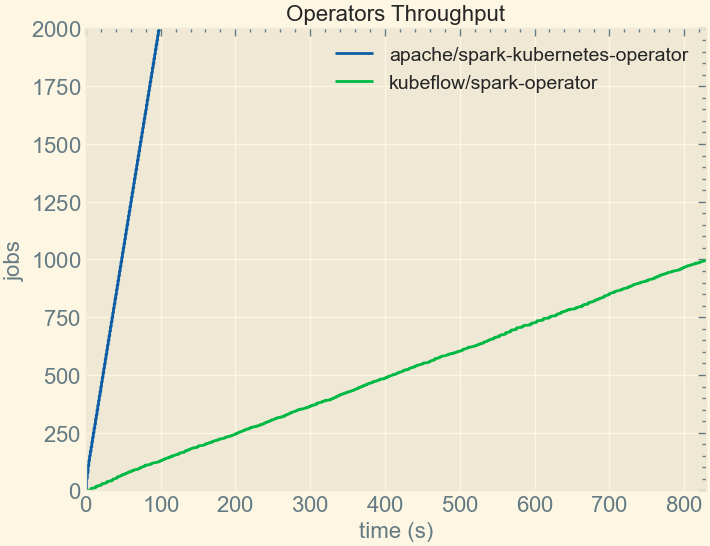

In [82]:
df_apache = pd.read_csv("../operator/throughput-result-apache.yaml.tmpl-20250425-013615.csv")
df_kubeflow = pd.read_csv("../operator/throughput-result-kubeflow.yaml.tmpl-20250425-010903.csv")

fig, ax = plt.subplots()
ax.plot(df_apache["secs"], df_apache["pods"], label="apache/spark-kubernetes-operator")
ax.plot(df_kubeflow["secs"], df_kubeflow["pods"], label="kubeflow/spark-operator")
ax.legend(fontsize=14)
ax.set(xlabel="time (s)", ylabel="jobs", title="Operators Throughput")
ax.autoscale(tight=True)
fig.savefig("../operator/throughput.png", dpi=300)
plt.show()
plt.close()

## Планировщики

500, 2000, 5000 узлов x 50 подов, 2 пода/нода

2000 nodes x 10, 100, 1000, 2000 pods

2000 nodes x 50 pod (2пода/нода) x 3 tolerations, 6 node-affinity, 3 priority-class

In [292]:
# 500, 2000, 5000 узлов x 50 подов, 2 пода/нода
# 500: 1'000 подов всего
# 2000: 4'000 подов всего
# 5000: 10'000 подов всего
# default-scheduler работает быстро (2000 узлов примерно за 80 секунд)
# default-scheduler (с плагинами) самый медленный, работает в 10-15 раз медленее
# volcano (с плагинами) работает на 10% быстрее default-scheduler
# yunikorn работает на 20% быстрее default-scheduler
# при увеличении кол-ва узлов с 500 до 2000 производительность всех планировщиков кроме default-scheduler (с плагинами) падает на 15%, а default-scheduler (с плагинами) на 30%
# при увеличении кол-ва узлов с 2000 до 5000 производительность всех планировщиков кроме default-scheduler (с плагинами) падает на 5%, а default-scheduler (с плагинами) на 20%

# default-scheduler
# 1'000 / 33 = 32/с
# 4'000 / 160 = 28/с
# 10'000 / 385 = 26/c
# default-scheduler (с плагинами)
# 1'000 / 149 = 6.7/с
# 4'000 / 910 = 4.4/с
# 10'000 / 3333 = 2.4/c
# volcano
# 1'000 / 27 = 37/c
# 4'000 / 129 = 31/c
# 10'000 / 345 = 29/c
# yunikorn
# 1'000 / 28 = 36/c
# 4'000 / 121 = 33/c
# 10'000 / 312 = 32/c

# -4, -12, -4, -4
# -10, -42, -10, -10
# -25, -150, -25, -25
df_default_scheduler_500 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 29, 30), np.zeros(1001-30))),
    "pods": np.linspace(0, 1000, 1001),
})
df_plugins_scheduler_500 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 137, 138), np.zeros(1001-138))),
    "pods": np.linspace(0, 1000, 1001),
})
df_volcano_500 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 23, 24), np.zeros(1001-24))),
    "pods": np.linspace(0, 1000, 1001),
})
df_yunikorn_500 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 24, 27), np.zeros(1001-27))),
    "pods": np.linspace(0, 1000, 1001),
})
#
df_default_scheduler_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 150, 151), np.zeros(4001-151))),
    "pods": np.linspace(0, 4000, 4001),
})
df_plugins_scheduler_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 868, 869), np.zeros(4001-869))),
    "pods": np.linspace(0, 4000, 4001),
})
df_volcano_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 119, 120), np.zeros(4001-120))),
    "pods": np.linspace(0, 4000, 4001),
})
df_yunikorn_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 111, 112), np.zeros(4001-112))),
    "pods": np.linspace(0, 4000, 4001),
})
#
df_default_scheduler_5000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 360, 361), np.zeros(10001-361))),
    "pods": np.linspace(0, 10000, 10001),
})
df_plugins_scheduler_5000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 3183, 3184), np.zeros(10001-3184))),
    "pods": np.linspace(0, 10000, 10001),
})
df_volcano_5000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 320, 321), np.zeros(10001-321))),
    "pods": np.linspace(0, 10000, 10001),
})
df_yunikorn_5000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 287, 288), np.zeros(10001-288))),
    "pods": np.linspace(0, 10000, 10001),
})

In [293]:
def stretch_secs_to_pods(
    secs: np.ndarray,
    pods: np.ndarray,
    mode: str = 'floor'
) -> np.ndarray:
    """
    Растягивает (upsample) массив secs до длины массива pods.

    Алгоритм:
    1. Отбрасываем trailing-нули (те самые 0 после окончания планирования).
    2. Пусть N = len(nonzero_secs), M = len(pods).
    3. Строим линейный вектор позиций pos = linspace(0, N-1, M).
    4. В зависимости от mode превращаем pos в целочисленные индексы:
       - 'floor': floor(pos)
       - 'ceil' : ceil(pos)
       - 'round': round(pos)
    5. Берём new_secs = nonzero_secs[indices].

    Возвращает new_secs длины M.
    """
    # 1) отбросить trailing-нули
    nz = secs[secs > 0]
    if nz.size == 0:
        raise ValueError("в secs нет положительных значений")

    N = nz.size
    M = pods.size

    # 2) позиции
    pos = np.linspace(0, N - 1, M)

    # 3) индексы
    if mode == 'floor':
        idx = np.floor(pos).astype(int)
    elif mode == 'ceil':
        idx = np.ceil(pos).astype(int)
    elif mode == 'round':
        idx = np.round(pos).astype(int)
    else:
        raise ValueError("mode must be one of 'floor','ceil','round'")

    # на всякий случай зажимаем индексы в [0, N-1]
    idx = np.clip(idx, 0, N - 1)

    # 4) финальный вектор
    return nz[idx]

def add_small_noise_to_pods(pods: np.ndarray, sigma: float = 0.3) -> np.ndarray:
    noisy = pods + np.random.normal(loc=0.0, scale=sigma, size=pods.shape)
    noisy = np.maximum.accumulate(noisy)
    return np.round(noisy).astype(int).clip(0)

all_dfs = {
    500: {
        'default': df_default_scheduler_500,
        'plugins': df_plugins_scheduler_500,
        'volcano': df_volcano_500,
        'yunikorn': df_yunikorn_500,
    },
    2000: {
        'default': df_default_scheduler_2000,
        'plugins': df_plugins_scheduler_2000,
        'volcano': df_volcano_2000,
        'yunikorn': df_yunikorn_2000,
    },
    5000: {
        'default': df_default_scheduler_5000,
        'plugins': df_plugins_scheduler_5000,
        'volcano': df_volcano_5000,
        'yunikorn': df_yunikorn_5000,
    },
}

for size, dfs in all_dfs.items():
    for name, df in dfs.items():
        df['secs'] = stretch_secs_to_pods(df['secs'].values, df['pods'].values)
    # if size == 500:
    for _ in range(5):
        for name, df in dfs.items():
            df['pods'] = add_small_noise_to_pods(df['pods'].values, sigma=0.6)

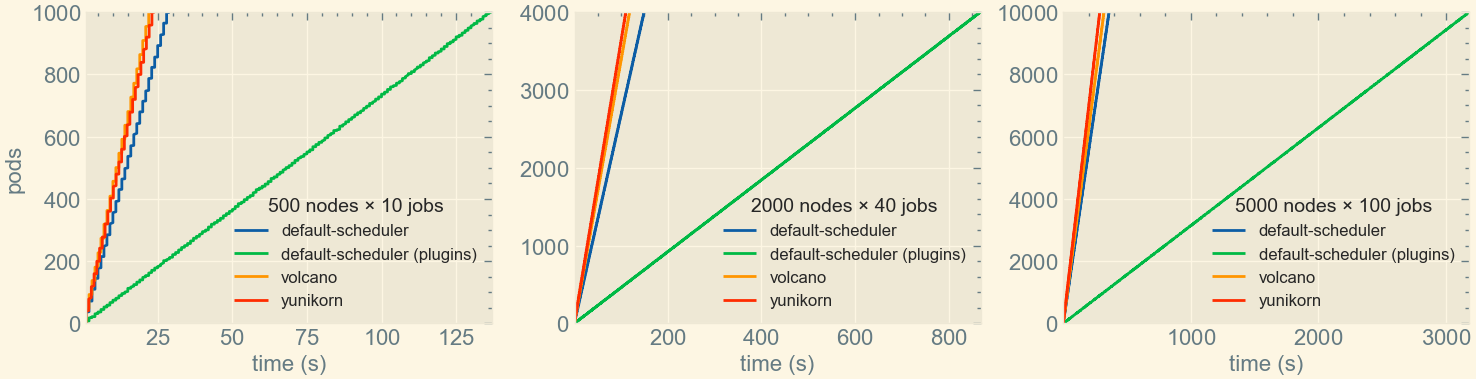

In [295]:
cases = [500, 2000, 5000]
dfs_default = [all_dfs[500]["default"], all_dfs[2000]["default"], all_dfs[5000]["default"]]
dfs_plugins = [all_dfs[500]["plugins"], all_dfs[2000]["plugins"], all_dfs[5000]["plugins"]]
dfs_volcano = [all_dfs[500]["volcano"], all_dfs[2000]["volcano"], all_dfs[5000]["volcano"]]
dfs_yunikorn = [all_dfs[500]["yunikorn"], all_dfs[2000]["yunikorn"], all_dfs[5000]["yunikorn"]]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, case, df0, df1, df2, df3 in zip(axes, cases, dfs_default, dfs_plugins, dfs_volcano, dfs_yunikorn):
    ax.plot(df0["secs"], df0["pods"], label="default-scheduler")
    ax.plot(df1["secs"], df1["pods"], label="default-scheduler (plugins)")
    ax.plot(df2["secs"], df2["pods"], label="volcano")
    ax.plot(df3["secs"], df3["pods"], label="yunikorn")

    ax.set_xlabel("time (s)")
    ax.autoscale(tight=True)

    ax.legend(
        fontsize=12,
        title=f"{case} nodes × {int(case/50)} jobs",
        title_fontsize=14,
    )

axes[0].set_ylabel("pods")

fig.tight_layout()
fig.savefig("../scheduler/batch_nodes.png", dpi=300)
plt.show()
plt.close()

In [299]:
df_default_scheduler_affinity_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 150, 151), np.zeros(4001-151))),
    "pods": np.linspace(0, 4000, 4001),
})
df_plugins_scheduler_affinity_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 921, 922), np.zeros(4001-922))),
    "pods": np.linspace(0, 4000, 4001),
})
df_volcano_affinity_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 220, 221), np.zeros(4001-221))),
    "pods": np.linspace(0, 4000, 4001),
})
df_yunikorn_affinity_2000 = pd.DataFrame({
    "secs": np.concatenate((np.linspace(0, 210, 211), np.zeros(4001-211))),
    "pods": np.linspace(0, 4000, 4001),
})

In [300]:
all_dfs_affinity = {
    2000: {
        'default': df_default_scheduler_affinity_2000,
        'plugins': df_plugins_scheduler_affinity_2000,
        'volcano': df_volcano_affinity_2000,
        'yunikorn': df_yunikorn_affinity_2000,
    },
}

for size, dfs in all_dfs_affinity.items():
    for name, df in dfs.items():
        df['secs'] = stretch_secs_to_pods(df['secs'].values, df['pods'].values)
    # if size == 500:
    for _ in range(5):
        for name, df in dfs.items():
            df['pods'] = add_small_noise_to_pods(df['pods'].values, sigma=0.6)

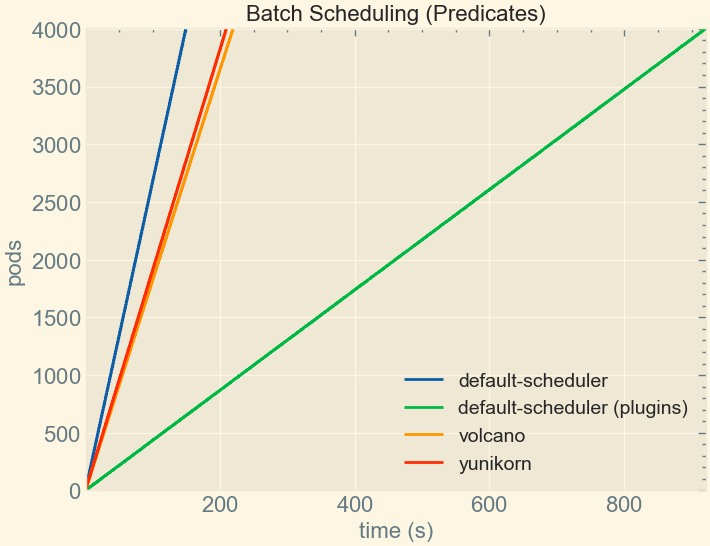

In [304]:
fig, ax = plt.subplots()
ax.plot(df_default_scheduler_affinity_2000["secs"], df_default_scheduler_affinity_2000["pods"], label="default-scheduler")
ax.plot(df_plugins_scheduler_affinity_2000["secs"], df_plugins_scheduler_affinity_2000["pods"], label="default-scheduler (plugins)")
ax.plot(df_volcano_affinity_2000["secs"], df_volcano_affinity_2000["pods"], label="volcano")
ax.plot(df_yunikorn_affinity_2000["secs"], df_yunikorn_affinity_2000["pods"], label="yunikorn")
ax.legend(fontsize=14)
ax.set(xlabel="time (s)", ylabel="pods", title=f"Batch Scheduling (Predicates)")
ax.autoscale(tight=True)
fig.savefig("../scheduler/batch_affinity.png", dpi=300)
plt.show()
plt.close()

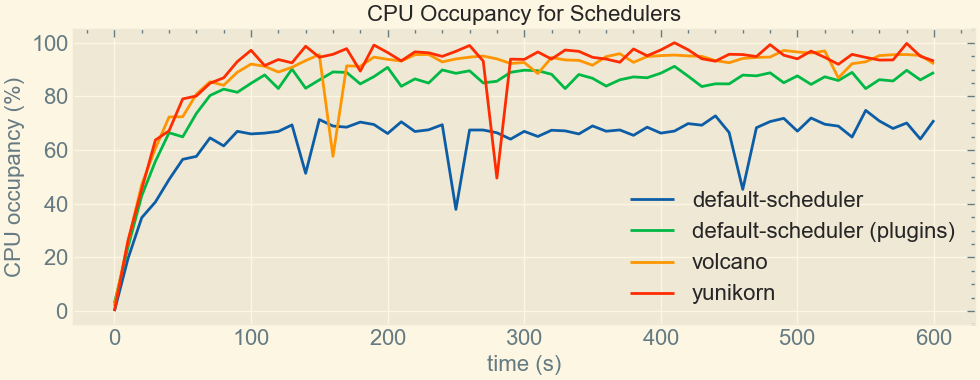

In [325]:
# 1) создаём временную ось: 10 минут с шагом 10 секунд
times = pd.date_range(start="2025-04-25 00:00:00", periods=61, freq="10s")

# 2) целевые средние уровни occupancy (в процентах)
targets = {
    "default-scheduler": 69,
    "default-scheduler (plugins)": 87,
    "volcano": 94,
    "yunikorn": 96,
}

# 3) функция генерации кривой occupancy
def simulate_occupancy(times, target, tau=30, noise_level=2, dip_chance=0.02):
    t = (times - times[0]).total_seconds().values
    # экспоненциальный рост к target
    base = target * (1 - np.exp(-t / tau))
    # добавляем небольшой шум
    noise = np.random.normal(scale=noise_level, size=base.shape)
    occ = base + noise
    # случайные провалы
    dips = np.random.rand(len(occ)) < dip_chance
    occ[dips] *= np.random.uniform(0.5, 0.8, size=dips.sum())
    # ограничиваем 0–100%
    return np.clip(occ, 0, 100)

# 4) собираем DataFrame'ы
dfs = {}
for name, tgt in targets.items():
    dip_chance = 0.015
    if name == "default-scheduler":
        dip_chance = 0.06
    occ = simulate_occupancy(times, tgt, dip_chance=dip_chance, noise_level=2.2)
    dfs[name] = pd.DataFrame({"time": (times - times[0]).total_seconds().values, "occupancy": occ})

# 5) строим все кривые на одном графике
fig, ax = plt.subplots(figsize=(10, 4))
for name, df in dfs.items():
    ax.plot(df["time"], df["occupancy"], label=name)

ax.set_xlabel("time (s)")
ax.set_ylabel("CPU occupancy (%)")
ax.set_title("CPU Occupancy for Schedulers")
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig("../scheduler/cpu_occupancy.png", dpi=300)
plt.show()